In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _canoeValues as cv

#-------------------Inputs-------------------------------------------------------------
input_files = ["Shear_and_Moment_6 Paddlers.csv", "Shear_and_Moment_4 Paddlers.csv", "Shear_and_Moment_3 Paddlers.csv", "Shear_and_Moment_2 Paddlers.csv", "Shear_and_Moment_Display_Stand.csv"]
shear_files = ["Length_vs_Shear_6 Paddler.csv", "Length_vs_Shear_4 Paddler.csv", "Length_vs_Shear_2 Paddler.csv", "Length_vs_Shear_Display_Stand.csv", ]
hf = cv.concrete_thickness # [mm]
f_c = cv.compressive_strength # [MPa]
lamda = cv.lamda
beta = cv.beta
layer1 = cv.hasLayer1 # if layer exists, it equals to 1. Otherwise, Xero.
layer2 = cv.hasLayer2 # if layer exists, it equals to 1. Otherwise, Xero.
d_mesh_1 = cv.d_mesh_1 # distance b/w the first layer of reinforcement to the surface [mm]
d_mesh_2 = cv.d_mesh_2 # distance b/w the second layer of reinforcement to the surface [mm]
concrete_thickness = cv.concrete_thickness
#-----------Reinforcement Property-------------
phi_s = cv.phi_s
fy = cv.fy # [MPa]
phi_c = cv.phi_c
E_s = cv.E_s # [MPa]
layer_unit_1 = cv.layer_unit_1 # one lap for layer 1 [mm^2/m]
layer_unit_2 = cv.layer_unit_2 # one lap for layer 2
#--------------------------------------------------------------------------------------

script_dir = os.path.abspath('data')

inner_file = "Inner Hull.csv"
outer_file = "Outer Hull.csv"

file_path = os.path.join(script_dir, inner_file) # file path for the text file input
in_coor = pd.read_csv(file_path, header=None)

file_path = os.path.join(script_dir, outer_file) # file path for the text file input
out_coor = pd.read_csv(file_path, header=None)

# Get inner and outer hull coordinates (station points)
x_in = in_coor[0]
y_in = in_coor[1]
z_in = in_coor[2]

x_out = out_coor[0]
y_out = out_coor[1]
z_out = out_coor[2]

station_no = x_out.nunique() # number of stations
station_out = x_out.unique() # location of each station
station_in = x_in.unique()


# Calculate y-bar and Q

In [2]:
# for input_file in input_files:
#     file_path = os.path.join(script_dir, input_file)
#     info = pd.read_csv(file_path, header=None)
#     print(input_file)

#     #x_coor = coordinates[0].iloc[1:] # get rid of [0,0,0]
#     x_in = in_coor[0]
#     y_in = in_coor[1]
#     z_in = in_coor[2]

#     x_out = out_coor[0]
#     y_out = out_coor[1]
#     z_out = out_coor[2]

#     station_no = x_out.nunique() # number of stations
#     station_out = x_out.unique() # location of each station
#     station_in = x_in.unique()

#     # Positive Shear
#     value = float(info[1][1])
#     width = float(info[3][1])
#     depth = float(info[4][1])
#     target_station = float(info[2][1])

#     # Extract Station Information
#     Y1_in = []; Z1_in = []
#     Y2_in = []; Z2_in = []
#     Y1_out = []; Z1_out = []
#     Y2_out = []; Z2_out = []

#     for k in range(1,station_no-2,1):
#         if k == target_station:
#             X1_in = station_in[k]
#             X2_in = station_in[k+1]
#             X1_out = station_out[k]
#             X2_out = station_out[k+1]
            
#             for i in range(0,len(x_out),1):
#                 if x_out[i] == X1_out:
#                     Y1_out.append(y_out[i])
#                     Z1_out.append(z_out[i])

#                 elif x_out[i] == X2_out:
#                     Y2_out.append(y_out[i])
#                     Z2_out.append(z_out[i])
                
#                 if x_in[i] == X1_in:
#                     Y1_in.append(y_in[i])
#                     Z1_in.append(z_in[i])

#                 elif x_in[i] == X2_in:
#                     Y2_in.append(y_in[i])
#                     Z2_in.append(z_in[i])

#     #if(input_file == "Shear_and_Moment_4 Paddlers.csv"):

#     # Find y_bar
#     volume = 0
#     product = 0 # y_bar * Volume
#     for i in range(0,len(Y1_out)-1,1):
#         #print("Y1 (in, out) : (" + str(Y1_in[i]) + ", " + str(Y1_out[i]) + ")\n" + "Z1 (in, out) : (" + str(Z1_in[i]) + ", " + str(Z1_out[i]) + ")")
#         #print("Y2 (in, out) : (" + str(Y2_in[i]) + ", " + str(Y2_out[i]) + ")\n" + "Z2 (in, out) : (" + str(Z2_in[i]) + ", " + str(Z2_out[i]) + ")\n")
#         z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
#         x = (abs(X1_in-X2_in) + abs(X1_out-X2_out))/2
#         y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
#         z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4

#         volume_i = x * y * z
#         volume += volume_i
#         product += volume_i * z_i

#     # ybar of the canoe
#     y_bar_top = abs(product/volume)
#     y_bar_bottom = depth - y_bar_top

#     # Find I
#     I = 0
#     for i in range(0,len(Y1_out)-1,1):
#         z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
#         y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
#         z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4
#         I_i = (1/12*y*z**3 + y*z*(abs(z_i) - y_bar_top)**2) # [mm^4]
#         I = I + I_i



#     # Find Q
#     A_top_total = 0
#     A_top_ybar_product = 0

#     for i in range(0,len(Y1_out)-1,1):
#         z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
#         y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
#         z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4

#         if(abs(z) <= abs(y_bar_top)):
#             A_top_total += y*z
#             A_top_ybar_product += A_top_total * z_i

#     A_top_ybar = A_top_ybar_product / A_top_total # mm

#     Q = A_top_total * abs(A_top_ybar - y_bar_top) # mm^3

#     tau_positive = value * Q / (I * concrete_thickness*2) # N * mm^3 / mm^4 * mm
#                                                     # N/mm^2 = MPa

#     print("I: " + str(I))
#     print("Q: " + str(Q))
#     print("Concrete Thickness * 2: " + str(concrete_thickness * 2))
#     print("Tau Positive: " + str(tau_positive) + " MPa\n")

Longitudinal Shear for Every Station:
Length_vs_Shear_6 Paddler.csv:
Max Shear Stress: 18.99996209637802 MPa
Min Shear Stress: -19.002177953366377 MPa


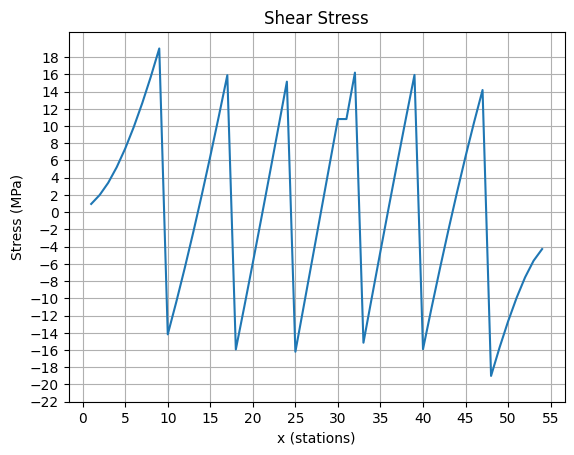

Length_vs_Shear_4 Paddler.csv:
Max Shear Stress: 19.048477409879055 MPa
Min Shear Stress: -17.004606684355295 MPa


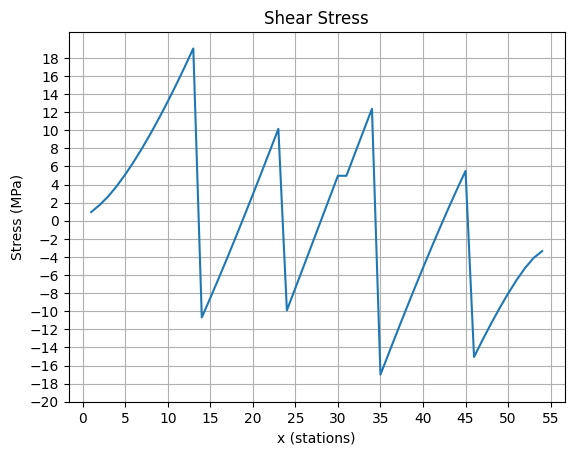

Length_vs_Shear_2 Paddler.csv:
Max Shear Stress: 18.670631880093147 MPa
Min Shear Stress: -18.625717189271114 MPa


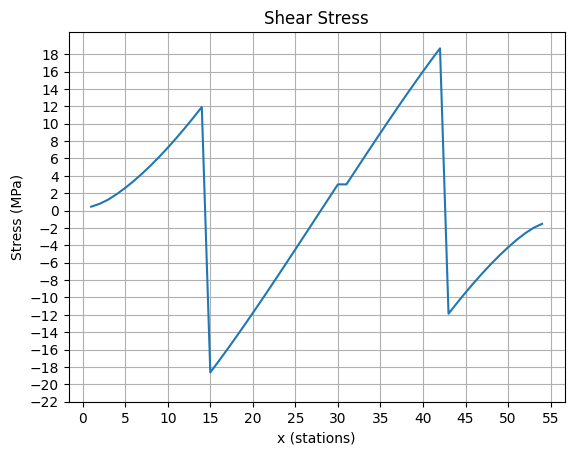

Length_vs_Shear_Display_Stand.csv:
Max Shear Stress: 11.045665688658179 MPa
Min Shear Stress: -10.08928367894959 MPa


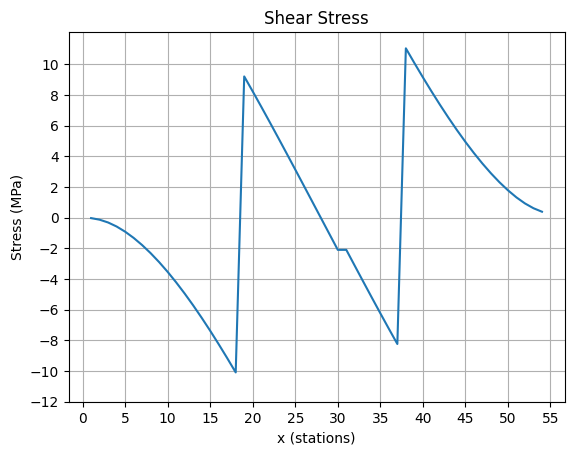

In [3]:
print("Longitudinal Shear for Every Station:")
# Loop through each load case
for input_file in shear_files:
    print("\033[4m" + input_file + ":\033[0m")

    # Get the shear for each station from the file
    file_path = os.path.join(script_dir, input_file)
    shearByLength = pd.read_csv(file_path, header=None)
    shearArray = []
    for i in range(len(station_in)):
        shearArray.append(shearByLength[2][i * round(len(shearByLength[0])/len(station_in)) + 1])

    # Initialize arrays to store each station's I, Q, and Tau
    # IArray = []
    # QArray = []
    TauArray = []

    # Loop through each station
    for k in range(1,station_no-2,1):


        # X-coordinates for the sides of this station
        X1_in = station_in[k]
        X2_in = station_in[k+1]
        X1_out = station_out[k]
        X2_out = station_out[k+1]
        
        # Arrays to store the YZ-coordinates of each point in the station (inner and outer hull)
        Y1_in = []; Z1_in = []
        Y2_in = []; Z2_in = []
        Y1_out = []; Z1_out = []
        Y2_out = []; Z2_out = []
        
        # Loop through each x coordinate and get every point in the cross-section
        for i in range(0,len(x_out),1):
            if x_out[i] == X1_out:
                Y1_out.append(y_out[i])
                Z1_out.append(z_out[i])

            elif x_out[i] == X2_out:
                Y2_out.append(y_out[i])
                Z2_out.append(z_out[i])
            
            if x_in[i] == X1_in:
                Y1_in.append(y_in[i])
                Z1_in.append(z_in[i])

            elif x_in[i] == X2_in:
                Y2_in.append(y_in[i])
                Z2_in.append(z_in[i])

        # Depth and Shear (Value) for each station
        depth = (abs(min(Z1_out))+abs(min(Z2_out)))/2
        value = float(shearArray[k])

        # Calculate the canoe's volume (intermediate step for y-bar)
        volume = 0
        product = 0 # y_bar * Volume
        for i in range(0,len(Y1_out)-1,1):
            #print("Y1 (in, out) : (" + str(Y1_in[i]) + ", " + str(Y1_out[i]) + ")\n" + "Z1 (in, out) : (" + str(Z1_in[i]) + ", " + str(Z1_out[i]) + ")")
            #print("Y2 (in, out) : (" + str(Y2_in[i]) + ", " + str(Y2_out[i]) + ")\n" + "Z2 (in, out) : (" + str(Z2_in[i]) + ", " + str(Z2_out[i]) + ")\n")
            z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
            x = (abs(X1_in-X2_in) + abs(X1_out-X2_out))/2
            y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
            z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4

            volume_i = x * y * z
            volume += volume_i
            product += volume_i * z_i

        # Calculate y-bar from the top and bottom
        y_bar_top = abs(product/volume)
        y_bar_bottom = depth - y_bar_top

        # Calculate I
        I = 0
        for i in range(0,len(Y1_out)-1,1):
            z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
            y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
            z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4
            I_i = (1/12*y*z**3 + y*z*(abs(z_i) - y_bar_top)**2) # [mm^4]
            I = I + I_i

        # Calculate A top (intermediate step for Q)
        A_top_total = 0
        A_top_ybar_product = 0

        for i in range(0,len(Y1_out)-1,1):
            z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
            y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
            z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4

            if(abs(z) <= abs(y_bar_top)):
                A_top_total += y*z
                A_top_ybar_product += A_top_total * z_i

        A_top_ybar = A_top_ybar_product / A_top_total # mm

        # Calculate Q and Tau
        Q = A_top_total * abs(A_top_ybar - y_bar_top) # mm^3
        tau_positive = value * Q / (I * concrete_thickness*2) # N * mm^3 / mm^4 * mm
                                                        # N/mm^2 = MPa

        # Store this station's I, Q and Tau in arrays
        # IArray.append(I)
        # QArray.append(Q)
        TauArray.append(tau_positive)

        # print("Station", k)
        # print("I:", I, "mm^4")
        # print("Q:", Q, "mm^3")
        # print("Tau Positive: " + str(tau_positive) + " MPa\n")

    print("Max Shear Stress:", max(TauArray), "MPa")
    print("Min Shear Stress:", min(TauArray), "MPa")

    # Plot shear stress for each load case
    plt.plot(range(1,station_no-2,1), TauArray)
    plt.title('Shear Stress')
    plt.xticks(np.arange(0, 56, 5))
    plt.xlabel('x (stations)')
    plt.yticks(np.arange(round(min(TauArray)) - (round(min(TauArray)) % 2 + 2),round(max(TauArray)) + 1, 2))
    plt.ylabel('Stress (MPa)')
    plt.grid()
    plt.show()


In [4]:
# Negative Tau - This has to be fixed
for input_file in input_files:
    file_path = os.path.join(script_dir, input_file)
    info = pd.read_csv(file_path, header=None)
    print(input_file)

    #x_coor = coordinates[0].iloc[1:] # get rid of [0,0,0]
    x_in = in_coor[0]
    y_in = in_coor[1]
    z_in = in_coor[2]

    x_out = out_coor[0]
    y_out = out_coor[1]
    z_out = out_coor[2]

    station_no = x_out.nunique() # number of stations
    station_out = x_out.unique() # location of each station
    station_in = x_in.unique()

    # Positive Shear
    value = float(info[1][2])
    width = float(info[3][2])
    depth = float(info[4][2])
    target_station = float(info[2][2])

    # Extract Station Information
    Y1_in = []; Z1_in = []
    Y2_in = []; Z2_in = []
    Y1_out = []; Z1_out = []
    Y2_out = []; Z2_out = []

    for k in range(1,station_no-2,1):
        if k == target_station:
            X1_in = station_in[k]
            X2_in = station_in[k+1]
            X1_out = station_out[k]
            X2_out = station_out[k+1]
            
            for i in range(0,len(x_out),1):
                if x_out[i] == X1_out:
                    Y1_out.append(y_out[i])
                    Z1_out.append(z_out[i])

                elif x_out[i] == X2_out:
                    Y2_out.append(y_out[i])
                    Z2_out.append(z_out[i])
                
                if x_in[i] == X1_in:
                    Y1_in.append(y_in[i])
                    Z1_in.append(z_in[i])

                elif x_in[i] == X2_in:
                    Y2_in.append(y_in[i])
                    Z2_in.append(z_in[i])

    # Find y_bar
    volume = 0
    product = 0 # y_bar * Volume
    for i in range(0,len(Y1_out)-1,1):
        #print("Y1 (in, out) : (" + str(Y1_in[i]) + ", " + str(Y1_out[i]) + ")\n" + "Z1 (in, out) : (" + str(Z1_in[i]) + ", " + str(Z1_out[i]) + ")")
        #print("Y2 (in, out) : (" + str(Y2_in[i]) + ", " + str(Y2_out[i]) + ")\n" + "Z2 (in, out) : (" + str(Z2_in[i]) + ", " + str(Z2_out[i]) + ")\n")
        z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
        x = (abs(X1_in-X2_in) + abs(X1_out-X2_out))/2
        y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
        z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4

        volume_i = x * y * z
        volume += volume_i
        product += volume_i * z_i

    # ybar of the canoe
    y_bar_top = abs(product/volume)
    y_bar_bottom = depth - y_bar_top

    # Find I
    I = 0
    for i in range(0,len(Y1_out)-1,1):
        z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
        y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
        z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4
        I_i = (1/12*y*z**3 + y*z*(abs(z_i) - y_bar_top)**2) # [mm^4]
        I = I + I_i



    # Find Q
    A_top_total = 0
    A_top_ybar_product = 0

    for i in range(0,len(Y1_out)-1,1):
        z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
        y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
        z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4

        if(abs(z) <= abs(y_bar_top)):
            A_top_total += y*z
            A_top_ybar_product += A_top_total * z_i

    A_top_ybar = A_top_ybar_product / A_top_total # mm

    Q = A_top_total * abs(A_top_ybar - y_bar_top) # mm^3

    tau_negative = abs(value * Q / (I * concrete_thickness*2)) # N * mm^3 / mm^4 * mm
                                                    # N/mm^2 = MPa

    torsion_negative = value * width/1000

    print("Tau Negative: " + str(tau_negative) + " MPa\n")

Shear_and_Moment_6 Paddlers.csv
Tau Negative: 22.535486363580137 MPa

Shear_and_Moment_4 Paddlers.csv
Tau Negative: 17.004606684355295 MPa

Shear_and_Moment_3 Paddlers.csv
Tau Negative: 28.959688095829524 MPa

Shear_and_Moment_2 Paddlers.csv
Tau Negative: 18.625717189271114 MPa

Shear_and_Moment_Display_Stand.csv
Tau Negative: 11.045665746259692 MPa

